# BERTopic Topic Modeling
* Notebook by Adam Lang
* Date: 6/7/2024
* We will go over the details of using the BERTopic model for topic modeling.
* This has been mentioned as a great data science tool for modeling and clustering semantic topics in the NLP space as well as for creating semantic clusters of topics when creating training data or fine tuning large language model and RAG applications.

# Topic Model Question: Why use BERTopic instead of LDA or another method?
* Answer: BERTopic is able to leverage embeddings and the encoder transformer model to learn semantic context using attention mechanism. Therefore context length or order of words is not an issue as the transformer based model is able to extract meaning in parallel.
  * Long range dependencies are one of the strong points of using a transformer based model.
* Also, using a BERT based model rather than a GPT (decoder only) based model is more ideal for this work because decoder models are trained to look left and predict right. The decoder models are naive only to the previous context you have given it rather than the entire sequence in parallel.
* However, this is not to say that LDA or TF-IDF or Top2Vec are not useful algorithms, they do have their unique use cases.


# When to use each Topic Model Algorithm?
* One study by Egger et al. published a great comparison table of techniques:

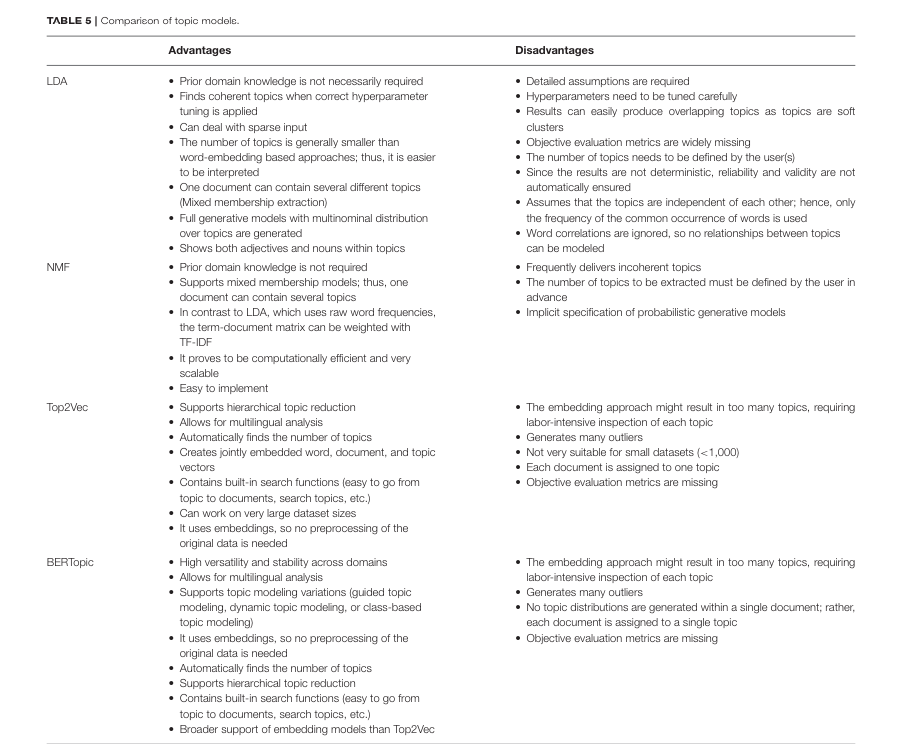

Source: Egger R, Yu J. A Topic Modeling Comparison Between LDA, NMF, Top2Vec, and BERTopic to Demystify Twitter Posts. Front Sociol. 2022 May 6;7:886498. doi: 10.3389/fsoc.2022.886498.

paper link: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9120935/

# BERTopic Algorithm - Overview
* BERTopic is a topic modeling technique that leverages 🤗 transformers and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions.
* Original paper: https://arxiv.org/pdf/2203.05794

# Steps
1. Build your model
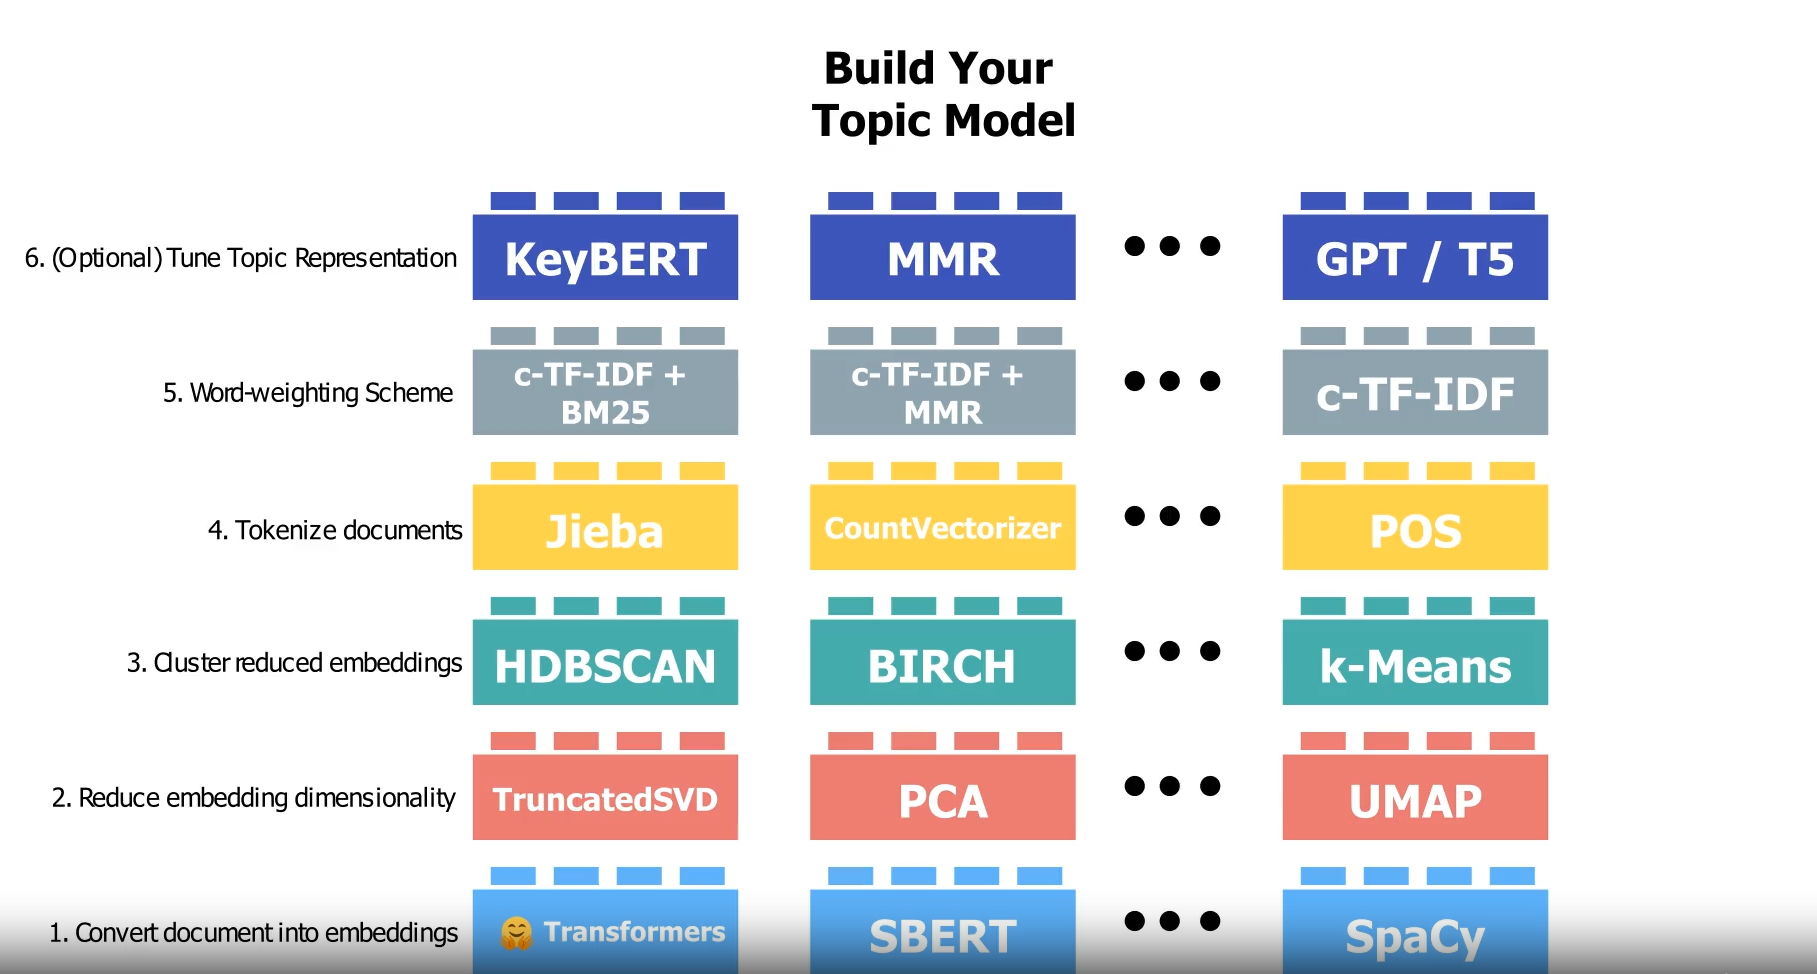

2. Reduce Dimensionality
3. Cluster Embeddings
4. Tokenize documents
5. Word weight schema
6. Tune topic representation (optional)

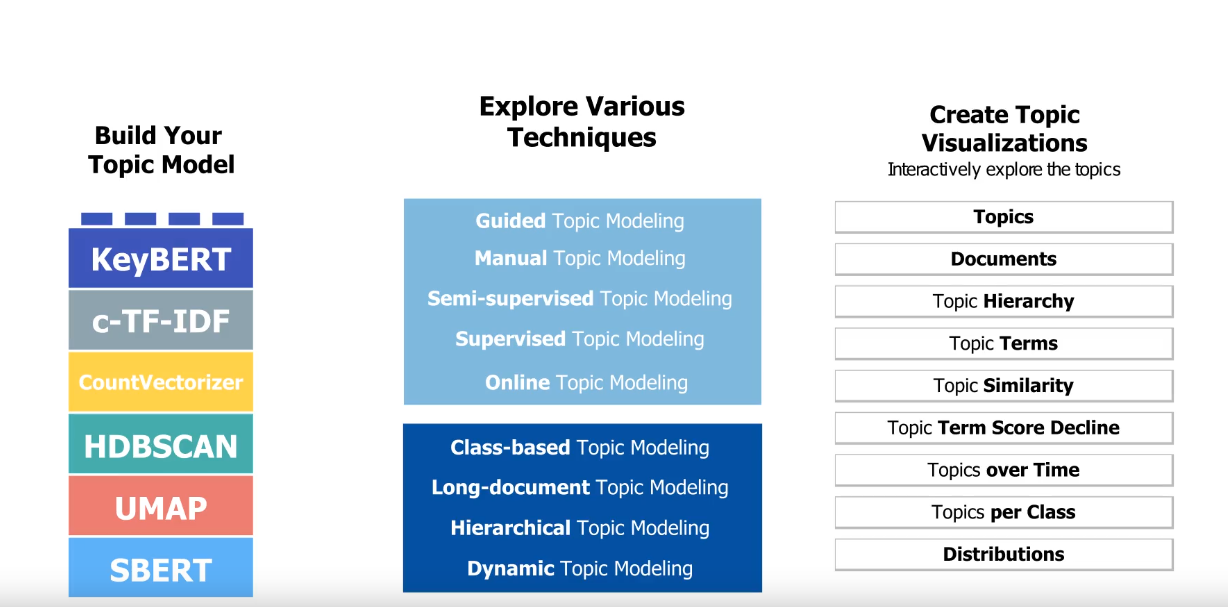

Another view of the algorithm workflow:

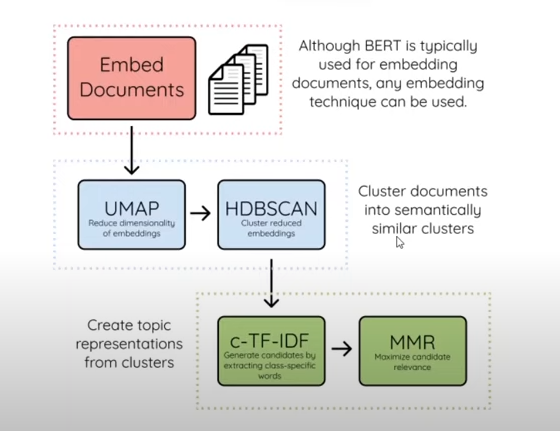

# 3 Main Stages of Algorithm
1. Embed documents
  * extract document based embeddings using BERT based models (e.g. SBERT sentence transformers) or another technique.

2. Cluster Documents
  * UMAP to reduce embedding dimensions.
  * HBDSCAN to cluster the reduced embeddings and create clusters of semantically similar documents.

3. Create the topic representation
  * Use TF-IDF to extract and reduce topics.
  * Use Maximal Marginal Relevance to improve the coherence and diversity of words.


# How do we get the topic representations?
* This uses a basic modification of TF-IDF algorithm: `c-TF-ICF`
    * Term x within class c
Steps:
1. Each cluster is converted into a single document NOT a set of documents.
2. Extract frequency of word x in class where c is the cluster we create.
3. Class representations are created.
4. Log of 1 plus average num of words per class divided by frequency of word x across ALL classes.
5. Add +1 within algorithm to force ALL VALUES TO POSITIVE integers.
6. TF-IDF now created
7. Similar to TF-IDF, then multiply TF with TDF --> word importance score per class.

Calculation

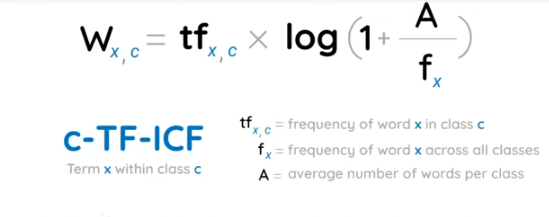

### Optional - Maximal Marginal Relevance Coherence
*  MMR tries to reduce the redundancy of results while at the same time maintaining query relevance of results for already ranked documents/phrases etc.
* Original paper: https://www.cs.cmu.edu/~jgc/publication/The_Use_MMR_Diversity_Based_LTMIR_1998.pdf

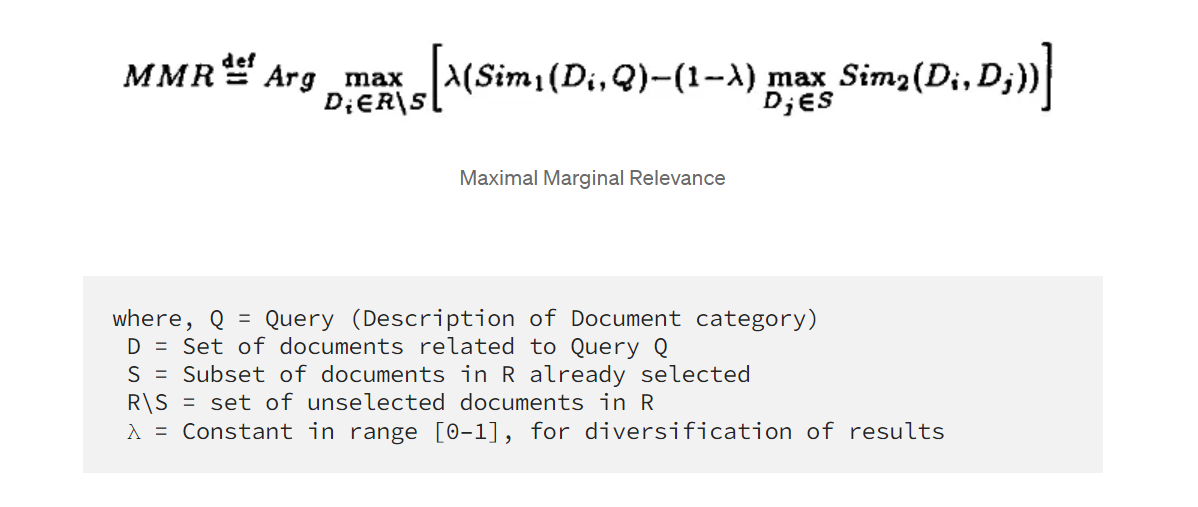

# BERTopic Implementation

In [1]:
## imports
import pandas as pd
import numpy as np
import json

## Dataset
* We will use the famous arxiv dataset from kaggle: https://www.kaggle.com/datasets/Cornell-University/arxiv

In [2]:
!pip install kaggle

We will use the Kaggle API to get the dataset

In [3]:
import os
import zipfile

# Download the dataset
os.system('kaggle datasets download -d Cornell-University/arxiv')

# Unzip the dataset
with zipfile.ZipFile('arxiv.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

We will used `yield` to load the JSON file in a loop to prevent memory issues with Python if JSON file is loaded direct.

In [4]:
data_file = 'arxiv-metadata-oai-snapshot.json'

def get_metadata():
    with open(data_file, 'r') as f:
        for line in f:
            yield line

Get the file metadata

In [5]:
metadata = get_metadata()
ids = []
titles = []
abstracts = []
categories = []

# loop through the metadata
for paper in metadata:
  metaDict = json.loads(paper)
  try:
    try:
      year = int(metaDict['journal-ref'][-4:])
    except:
      year = int(metaDict['journal-ref'][-5:-1])
      # appending id, title, cat based on year
    if(year == 2020 or year == 2019 or year == 2018):
      ids.append(metaDict['id'])
      titles.append(metaDict['id'])
      abstracts.append(metaDict['abstract'])
      categories.append(metaDict['categories'])
  except:
    pass


Create a dataframe to store the filtered data

In [6]:
df = pd.DataFrame({'id' : ids,'title' : titles,'abstract' : abstracts, 'categories' : categories})

#head of df
df.head()

,id,title,abstract,categories
0,0708.0070,0708.0070,We develop an extension of Bohmian mechanics...,quant-ph
1,0709.1457,0709.1457,Spin-orbit interaction lifts accidental band...,cond-mat.other
2,0710.1849,0710.1849,In this work we consider a question in the c...,math.DG math.AP math.MG
3,0712.1975,0712.1975,We have carried out a comprehensive investig...,cond-mat.str-el cond-mat.mtrl-sci
4,0804.3104,0804.3104,The Gibbs measure theory for smooth potentia...,math.DS math.CV


In [7]:
# what is len of df?
print(len(df))

90957


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90957 entries, 0 to 90956
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          90957 non-null  object
 1   title       90957 non-null  object
 2   abstract    90957 non-null  object
 3   categories  90957 non-null  object
dtypes: object(4)
memory usage: 2.8+ MB


In [9]:
## print category list
cat_list = df['categories'].unique()
print(*cat_list, sep= "\n")

Streaming output truncated to the last 5000 lines.
physics.soc-ph physics.ao-ph
math.MG math-ph math.AP math.MP
math.AC math.AG math.RT
physics.optics physics.app-ph physics.class-ph
math.DG math.GT
quant-ph cs.DS math.OC
nlin.SI nlin.PS physics.flu-dyn
hep-th math.CA
physics.soc-ph math.SP
physics.soc-ph cs.CY cs.MA
gr-qc cond-mat.quant-gas
physics.plasm-ph astro-ph.SR cond-mat.stat-mech physics.flu-dyn
cs.NI cs.CY
physics.ins-det physics.plasm-ph
hep-ph astro-ph.SR nucl-th physics.space-ph
math.FA math-ph math.MG math.MP
hep-ph astro-ph.CO astro-ph.GA
astro-ph.HE astro-ph.SR physics.plasm-ph
cond-mat.dis-nn cs.CL cs.FL
cond-mat.quant-gas cond-mat.other physics.atm-clus physics.atom-ph quant-ph
cond-mat.mes-hall cond-mat.quant-gas cond-mat.stat-mech quant-ph
cond-mat.soft physics.bio-ph q-bio.TO
cond-mat.dis-nn cond-mat.stat-mech q-bio.NC
hep-ph astro-ph.CO physics.ins-det physics.optics
physics.flu-dyn astro-ph.GA nlin.CD
cs.SD cs.AI eess.AS
math-ph cond-mat.quant-gas cond-mat.str-el

Exctract computer science publications

In [10]:
ml_df = df[df['categories'].str.contains("cs.")]

# extract cs pubs to list
sentencesList = ml_df['abstract'].tolist()

In [11]:
## ml_df head
ml_df.head()

,id,title,abstract,categories
5,0806.3026,0806.3026,In this paper we leave the neighborhood of t...,physics.gen-ph
8,0810.3615,0810.3615,Closed form analytical expressions are obtai...,physics.atom-ph
11,0811.2551,0811.2551,EVOC (for EVOlution of Culture) is a compute...,cs.MA cs.AI q-bio.NC
13,0901.0172,0901.0172,In this study the numerical performance of t...,physics.flu-dyn math.NA physics.comp-ph
14,0901.4075,0901.4075,We discuss epistemological and methodologica...,physics.data-an physics.hist-ph physics.pop-ph


In [12]:
## what is len of ml_df
print(len(ml_df))

27655


Summary:
* We now see that we have 27,655 documents.

In [13]:
## lets print 1 of the documents
print(sentencesList[1])

  Closed form analytical expressions are obtained for the Wigner transform of
the Bloch density matrix and for the Wigner phase space density of a two
dimensional harmonically trapped charged quantum gas in a uniform magnetic
field of arbitrary strength, at zero and nonzero temperatures. An exact
analytic expression is also obtained for the autocorrelation function. The
strong magnetic field case, where only few Landau levels are occupied, is also
examined, and useful approximate expressions for the spatial and momentum
densities are given.



In [14]:
## now lets trim this down to a sample of 2500 sentences
## for topic modeling
sampleSentencesList = sentencesList[1:2501]

In [15]:
## what is len of sample?
print(len(sampleSentencesList))

2500


# BERTopic steps

In [16]:
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 8.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 M

In [17]:
from bertopic import BERTopic

## Step 1: Create topic model

In [18]:
## setting calculate_probabilities=True --> viz topic distributions
topic_model = BERTopic(calculate_probabilities=True)

# fit model
topics, probabilities = topic_model.fit_transform(sampleSentencesList)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [19]:
## get topics list from model
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,748,-1_the_of_and_in,"[the, of, and, in, to, is, for, we, that, with]",[ We propose an exponential integrator for th...
1,0,212,0_networks_network_of_the,"[networks, network, of, the, to, and, social, ...",[ Recent advances in data collection have fac...
2,1,193,1_quantum_the_codes_of,"[quantum, the, codes, of, channel, we, for, is...","[ ""Bounds on information combining"" are entro..."
3,2,71,2_graph_graphs_algorithm_we,"[graph, graphs, algorithm, we, problem, vertic...",[ Covering problems are classical computation...
4,3,69,3_cell_of_cells_the,"[cell, of, cells, the, and, in, we, to, model,...",[ One of the many ways cells transmit informa...
5,4,67,4_laser_electron_beam_the,"[laser, electron, beam, the, of, in, pulse, fi...",[ Laser wakefield accelerators (LWFA) hold gr...
6,5,66,5_saliency_image_deep_convolutional,"[saliency, image, deep, convolutional, to, ima...",[ This paper proposes a deep learning model t...
7,6,61,6_quantum_photon_photons_optical,"[quantum, photon, photons, optical, of, the, s...",[ Exploring the quantum behaviour of macrosco...
8,7,49,7_wave_the_and_of,"[wave, the, and, of, in, metamaterials, to, fo...",[ In this paper we propose a new metasurface ...
9,8,44,8_optical_frequency_comb_pulse,"[optical, frequency, comb, pulse, combs, solit...",[ Dual-comb spectroscopy is a powerful techni...


In [20]:
## sample a few topics by index - get most important words
## get word content
topic_model.get_topic(0)

[('networks', 0.01938852758727694),
 ('network', 0.0188777679089446),
 ('of', 0.01834825602960122),
 ('the', 0.0171452275655408),
 ('to', 0.016179614726020638),
 ('and', 0.015945564379825437),
 ('social', 0.014935126243166284),
 ('we', 0.014599479383663317),
 ('in', 0.01458993397723474),
 ('that', 0.013290784602285634)]

In [21]:
## sample a few topics by index - get most important words
topic_model.get_topic(40)

[('deep', 0.04012997693120708),
 ('neural', 0.030887219486445197),
 ('learning', 0.025876930200191876),
 ('machine', 0.02163799956332001),
 ('networks', 0.020067142124223867),
 ('cv', 0.019861586019320445),
 ('the', 0.01981242861627686),
 ('phase', 0.01828642975250007),
 ('physical', 0.018223121767062696),
 ('network', 0.018212947701643386)]

### Visualize Topics
* Look at c-TF-ICF scores

In [22]:
topic_model.visualize_barchart(top_n_topics=10)

### Intertopic Distance Measures
* Visualize topics, their sizes, and their corresponding words
* This visualization is highly inspired by LDAvis, a great visualization
technique typically reserved for LDA.

In [23]:
## visualize the intertopic distance
topic_model.visualize_topics()

### Similarity Matrix

In [24]:
## viualize heatmap (similarity matrix)
topic_model.visualize_heatmap()

Summary:
* We can now more clearly see which topics are more similar.
* The darker the color, the more similar the topics are.

### Hierarchical Clustering

In [25]:
topic_model.visualize_hierarchy()

### Visualize Topic Probability Distributions

In [26]:
topic_model.visualize_distribution(probabilities[1])

Summary
* We can say that this specific document is dominated by 1 topic! This is a unique finding but it can really help when you are analyzing and building a language model application.

### Visualize another Document Prob Distribution

In [27]:
topic_model.visualize_distribution(probabilities[200])

Summary
* This document is dominated by Topic 1.

### Visualize another document probability distribution


In [28]:
topic_model.visualize_distribution(probabilities[5])

## Step 2: Dimensionality Reduction
* Various Techniques to do this:
    * PCA
    * UMAP
    * NMF
    * t-SNE

* You can pick and choose based on your data and goals which techniques you want to mix and match.
* Below we can see we used:
1. PCA for dimensionality reduction
2. KMeans for clustering technique
3. 'allenai-specter' for embedding model
  * This comes from sentence transformers library and is scientific specific as these are science domain papers.

* Depending on your data and domain and needs you can mix and match any unsupervised and supervised techniques and embeddings.

### Other important distinctions
* Depending upon the dimensionality reduction technique and/or the clustering algorithms, you may need to pre-process your data using classical NLP techniques.
* If you see topics that are dominated by "stop words" then you may need to do this to get more semantic meaning out of our topic modeling.
* This is especially a problem if your corpus of documents/data is dominated by stop words, it will confuse the algorithmic results.

In [29]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [30]:
## instantiate dimensionality technique + cluster technique
## instead of UMAP using PCA, but can pick what you need!
dim_model = PCA(n_components=5)
cluster_model = KMeans(n_clusters=50)

## use topic model
topic_model = BERTopic(umap_model=dim_model,
                       embedding_model='allenai-specter',
                       hdbscan_model=cluster_model,
                       calculate_probabilities=True)

## fit_transform on documents
topics, probabilities = topic_model.fit_transform(sampleSentencesList)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.77k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/622 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/331 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/462k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [31]:
## get into for topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,99,0_networks_of_the_network,"[networks, of, the, network, to, dynamics, mod...","[ In the social, behavioral, and economic sci..."
1,1,96,1_of_networks_and_to,"[of, networks, and, to, social, the, in, we, t...","[ Driven by growing interest in the sciences,..."
2,2,92,2_algorithm_of_we_the,"[algorithm, of, we, the, problem, in, is, that...",[ Hash tables are ubiquitous in computer scie...
3,3,85,3_and_the_of_in,"[and, the, of, in, to, for, is, we, this, that]",[ Approximate message passing (AMP) refers to...
4,4,74,4_graphs_we_graph_of,"[graphs, we, graph, of, agents, to, the, netwo...",[ We study the problem of fairly allocating i...
5,5,66,5_and_to_of_data,"[and, to, of, data, the, on, in, that, we, is]",[ Methods that learn representations of nodes...
6,6,64,6_quantum_channel_channels_classical,"[quantum, channel, channels, classical, entang...","[ Recently, a coding technique called positio..."
7,7,64,7_codes_code_that_is,"[codes, code, that, is, we, of, for, the, line...",[ Linear codes with complementary duals (LCD)...
8,8,64,8_the_and_to_of,"[the, and, to, of, is, that, in, data, for, pr...",[ This paper addresses the problem of finding...
9,9,61,9_the_of_in_is,"[the, of, in, is, to, that, we, and, problem, ...",[ The problem of detecting changes with multi...


### Visualize

In [32]:
topic_model.visualize_barchart(top_n_topics=10)

### Visualize Intertopic Distance Map

In [33]:
topic_model.visualize_topics()

### Visualize Correlation Heatmap

In [34]:
topic_model.visualize_heatmap()

### Visualize Hierarchical Clustering

In [35]:
topic_model.visualize_hierarchy()